
<h1><center> <font color='black'>  Network Science (LTAT.02.011) - Homework - 02  (Total points - 15)</font></center></h1>
<h2><center> <font color='black'> Introduction to Network Analysis</font></center></h3>
<h2><center> <font color='black'> University of Tartu</font></center></h3>


================================================================================================================

# Homework instructions


- Please provide the names and student IDs of the team-members (Maximum 2 person) in the field "Team mates" below. If you are not working in a team please insert only your name and student ID. 

- ONLY one of the teammates should submit the homework. We will grade the homework and the marks and feedback is applied for both the team members. So please communicate with your team member about marks and feedback if you are submit the homework.


- The accepted submission format is .ipynb file. Please upload the file on moodle.

- The submission will automatically close on **<font color='red'>5th April 2023 at 23:59 pm</font>**, so please make sure you have enough time to submit the homework. 

- You do not necessarily need to work on Colab. Especially as the size and the complexity of datasets will increase through the course, you can install jupyter notebooks locally and work from there.

- If you do not understand what a question is asking for, please ask in Moodle. 

- Please Click on "**Restart and Run All**" before uploading the '.ipynb' file.

- Plagiarism is <font color='red'>**PROHIBITED**</font>. Any form of plagiarism will be dealt according to the university policy (https://www.ut.ee/en/current-students/academic-fraud).



**<h2><font color='red'>Student info:</font></h2>**


<font color='red'>Full Name:</font> Samir Musali

<font color='red'>Student ID:</font>C29810

================================================================================================================

# 1. Link prediction using varoius scoring method (5 points)

<font color='red'>At the start, we have provided the necessary codes. Please run all of these cells before starting tasks 1.1 through 1.3.</font>

In [24]:
#!pip install networkx==2.8 please install this version
#!pip install scipy==1.8.0 please install this version
!pip install networkx==2.8
!pip install scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx

In [3]:
# load nodes details
with open("fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("fb-pages-food.edges") as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(621, 2102)

In [4]:
# capture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})
fb_df = fb_df[fb_df.node_1 != fb_df.node_2]
fb_df.head()

100%|██████████| 2102/2102 [00:00<00:00, 588193.14it/s]


,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


In [5]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <= 2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1


node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)
    

# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

100%|██████████| 2091/2091 [00:11<00:00, 182.92it/s]
<ipython-input-5-22bf65a79512>:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)


In [6]:
data

,node_1,node_2,link
0,0,22,0
1,0,526,0
2,0,36,0
3,0,54,0
4,0,56,0
...,...,...,...
20485,576,584,1
20486,576,601,1
20487,584,603,1
20488,597,601,1


## **1.1. Calculate all the scores for every pair in "data" using graph "G_data". (4 points)**

<font color='red'>You can add extra cells if required.</font>

In [7]:
# 1. Number of common neighbors
data['common_neighbor'] = [len(list(nx.common_neighbors(G_data, u, v))) for u, v in zip(data['node_1'], data['node_2'])]

In [26]:
# 2. Jaccard coefficient
data['jaccard_similarity'] = [s for u, v, s in nx.jaccard_coefficient(G_data, ebunch=data[['node_1', 'node_2']].values)]

In [9]:
# 3. Adamic/Adar
data['adamic_adar_index'] = [s for u, v, s in nx.adamic_adar_index(G_data, ebunch=data[['node_1', 'node_2']].values)]

In [10]:
# 4. Shortest path
data['shortest_path'] = [nx.shortest_path_length(G_data, u, v) for u, v in zip(data['node_1'], data['node_2'])]

In [11]:
# 5. Preferrential attachment
data['preferential_attachment'] = [s for u, v, s in nx.preferential_attachment(G_data, ebunch=data[['node_1', 'node_2']].values)]

In [14]:
# 6. Hitting times
hitting_times = []
for i, (u, v) in data[['node_1', 'node_2']].iterrows():
    dist_u = nx.single_source_shortest_path_length(G_data, u)
    dist_v = nx.single_source_shortest_path_length(G_data, v)
    hitting_time = sum(dist_u[n] + dist_v[n] for n in G_data.nodes)
    hitting_times.append(hitting_time)
data['hitting_time'] = hitting_times

In [18]:
# 7. SimRank
simrank_scores = nx.simrank_similarity(G_data)
data['simrank'] = [simrank_scores[u][v] for u, v in zip(data['node_1'], data['node_2'])]

## **1.2. Create features and target value for the model. Split dataset into training and testing. (0.5 point)**

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [20]:
'''
Hint: Remove columns node_1, node_2 and link while creating "x" from data.
'''
x = data.drop(['node_1', 'node_2', 'link'], axis=1)
y = data['link']

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 35)

## **1.3. Apply logistic regression model and report auc roc score. (0.5 point)**

In [22]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(xtrain, ytrain)

LogisticRegression(class_weight='balanced')

In [23]:
predictions = lr.predict_proba(xtest)
roc_auc_score(ytest, predictions[:, 1])

0.8414754030505598

================================================================================================================

##2. Node2Vec (10 points)
documentation for reference - https://github.com/eliorc/node2vec  

# Dataset details:
**In this homework, the dataset consists of network of Wikipedia articles. That is, nodes consists of Wikipedia articles and edges are the connections between the two articles if one article has hyper-links of other article. Following are the steps to generate network dataset** - <br>
1. You are required to generate this type of network/graph from this [Website](https://densitydesign.github.io/strumentalia-seealsology/) (You can read more about its working on their webpage). 
2. After clicking this website link, you have to enter this URL https://en.wikipedia.org/wiki/Network_science in the text box shown on the webpage "Paste your list of wikipedia articles here" and put 2 in the "Distance" box if not already there. 
3. Then, click on "Start Crawling". 
4. Once the crawling is completed, you can download the "TSV" file in your local machine. This "TSV" file will be your edgelist, that is, each row consists of "source", "target" and "level"/"depth" information. <br>
Note: You can also see how the graph looks likes by scrolling down that website's page.

# Libraries

In [27]:
# Importing required libraries (install other libraries if needed)
!pip install node2vec
from node2vec import Node2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Reading the dataset

In [28]:
# import the "TSV" data file where edge list is stored (separated by tab) give the name of your file as 'network_science'
edges_list = pd.read_csv(r"network_science.tsv", sep = '\t')

In [29]:
# check first five rows of the dataframe (will use "depth" column later)
edges_list.head()

,source,target,depth
0,network science,cascading failure,1
1,network science,climate as complex networks,1
2,network science,collaborative innovation network,1
3,network science,communicative ecology,1
4,network science,complex network,1


In [30]:
# check shape of the dataframe
edges_list.shape

(239, 3)

# 2.1 Graph creation (1 point)

**2.1.1 Create undirected and unweighted graph using the edges_list dataset and check the basic properties (hint: graph info) of the graph such as number of nodes, average node degree, etc. Leave the "depth" column for now.  (0.50 points)** <br>

In [31]:
G = nx.Graph()

# add edges to the graph using edges_list dataframe
for i, elrow in edges_list.iterrows():
    G.add_edge(elrow[0], elrow[1])

In [32]:
# basic info of graph (use specific method from nx package)
print(nx.info(G))

Graph with 209 nodes and 232 edges


<ipython-input-32-48c9ace1c6cc>:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


**2.1.2 Plot the network graph (0.50 points)** <br>

In [33]:
import matplotlib.pyplot as plt

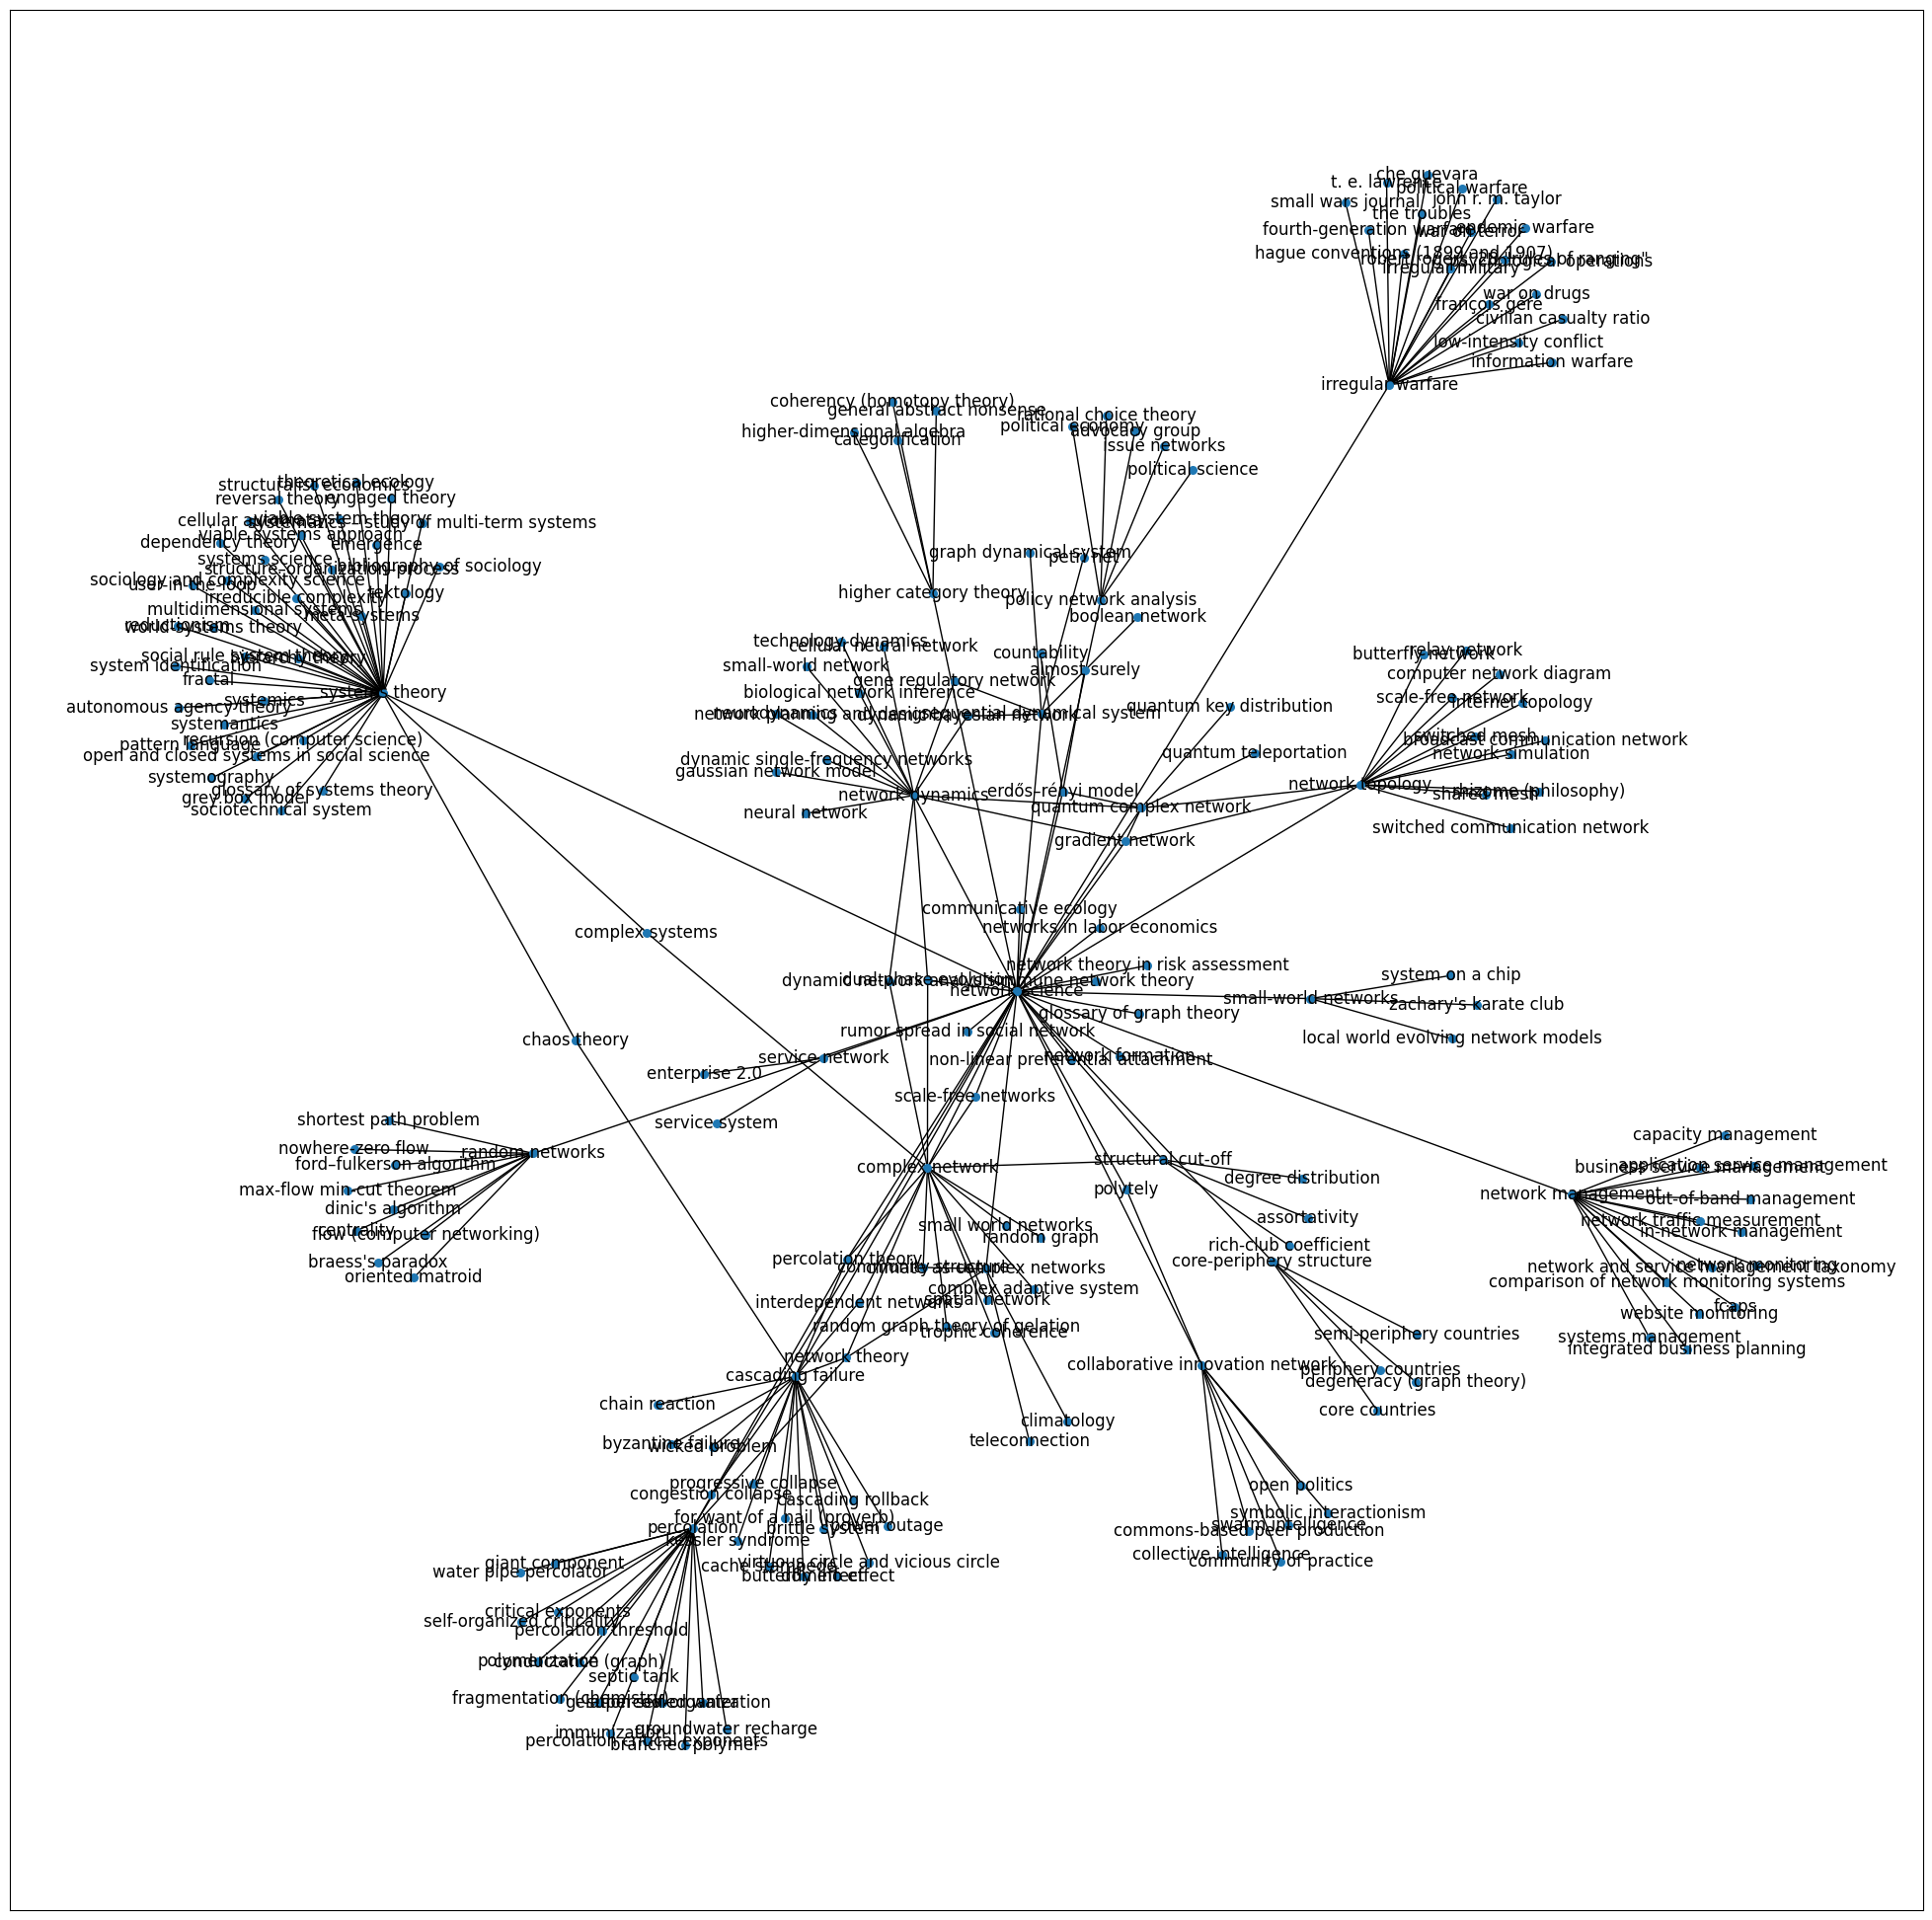

In [36]:
# Plot Graph
plt.figure(3, figsize=(25,25))
nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=True, node_size=30)
plt.show()

**<font color='red'>Your answer:</font>**

# 2.2 Node2Vec Embeddings (6 points)

**2.2.1. For the Graph G, created in task 2.1.1, use  Node2Vec for creating embeddings, with parameters - number of dimensions as 32, walk length as 10 and total number of walks as 50 and workers as 1 (0.50 point).**

In [37]:
# Precompute probabilities and generate walks
node2vec = Node2Vec(G, dimensions=32, walk_length=10, num_walks=50, workers=1)

Computing transition probabilities:   0%|          | 0/209 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 99.43it/s]


**2.2.2 For the Graph G, created in task 2.1.1, use  Node2Vec for creating embeddings, with parameters - p > 1 (anay value greater than 1) and q < 1 (anay value less than 1), number of dimensions as 32, walk length as 10 and total number of walks as 50 and workers as 1 (0.50 point).**

In [38]:
node2vec_modified_pq = Node2Vec(G, dimensions=32, walk_length=10, num_walks=50, workers=1, p=2, q=0.5)

Computing transition probabilities:   0%|          | 0/209 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 103.44it/s]


**2.2.3 For the Graph G, created in task 2.1.1, use  Node2Vec for creating embeddings, with parameters - p < 1 (anay value less than 1) and q > 1 (anay value greater than 1), number of dimensions as 32, walk length as 10 and total number of walks as 50 and workers as 1 (0.50 point).**

In [39]:
node2vec_modified_pq_again = Node2Vec(G, dimensions=32, walk_length=10, num_walks=50, workers=1, p=0.5, q=2)

Computing transition probabilities:   0%|          | 0/209 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 56.38it/s]


**2.2.4 When Node2vec and DeepWalk is considered to be similar? Also, what must have happened in terms of the structure of the embeddings when "p" and "q" parameters of Node2Vec are changed just like you did in all the three cases mentioned above? (0.50 point)** <br>
<font color='red'>Write your observation in the `Your answer` cell.</font>

**<font color='red'>Your answer:</font>** `Node2Vec` and `DeepWalk` are graph embedding techniques that aim to generate low-dimensional vector representations for nodes in a graph. They both use random walks to capture the local structure of the graph and represent nodes that appear in similar contexts with similar vectors in the embedding space.

The main difference between `Node2Vec` and `DeepWalk` is the random walk strategy used to generate node sequences. While `DeepWalk` performs a random walk with a fixed probability distribution over the neighbours, `Node2Vec` incorporates two additional parameters, `p` and `q`, that control the random walk behaviour. These parameters allow the random walk to explore both the breadth and depth of the graph, providing more flexibility in capturing the structural properties of the graph.

When the `p` and `q` parameters of `Node2Vec` are changed, the structure of the embeddings can be affected. Specifically, the `p` parameter controls the likelihood of revisiting nodes in the same part of the graph, while the `q` parameter controls the likelihood of moving away from the current part of the graph. By changing these parameters, we can create embeddings that emphasize different aspects of the graph structure. In the case where `p > 1` and `q < 1`, the random walk is more likely to stay in the local neighbourhood, resulting in embeddings that capture the community structure of the graph. Conversely, when `p < 1` and `q > 1`, the random walk is more likely to explore the broader context of the graph, resulting in embeddings that capture the global structure of the graph.

**2.2.5 Embed the nodes using "fit" function of Node2Vec created in 2.2.1. Keep the "window_count" paramater as 10 and "min_count" as 1. (0.50 point).**

In [40]:
# Embed nodes
model = node2vec.fit(window=10, min_count=1)

**2.2.6 Get the node embedding of 'network science' node. (0.50 point).**

In [41]:
# Get the vector of node 'network science'
node_embedding = model.wv['network science']

**2.2.7 Check which are the similar nodes with respect to 'network science' node. (0.50 point).**

In [44]:
# most similar nodes to node 'network science'
similar_nodes = model.wv.most_similar('network science')

print("Similar nodes to 'network science' node:")
for node in similar_nodes:
    print('\t', node[0], ': ', node[1])

Similar nodes to 'network science' node:
	 non-linear preferential attachment :  0.7371373772621155
	 networks in labor economics :  0.7290905714035034
	 immune network theory :  0.7079008221626282
	 network theory in risk assessment :  0.6781070232391357
	 communicative ecology :  0.675054669380188
	 glossary of graph theory :  0.663723886013031
	 rumor spread in social network :  0.6611701846122742
	 network formation :  0.6122252941131592
	 polytely :  0.539979875087738
	 scale-free networks :  0.5357292294502258


**2.2.8 According to you, which node(s) have given you the correct embedding (Hint: this can be verified by looking at the network graph). (0.75 point).**

In [45]:
#TODO

**<font color='red'>Your answer:</font>**
*   non-linear preferential attachment :  0.7371373772621155
*   networks in labor economics :  0.7290905714035034
*   immune network theory :  0.7079008221626282
*   glossary of graph theory :  0.663723886013031
*   polytely :  0.539979875087738






**2.2.9 According to you, which node(s) have given you the incorrect embedding (Hint: this can be verified by looking at the network graph). (0.75 point).**

In [46]:
#TODO

**<font color='red'>Your answer:</font>**

**2.2.10 Save the node embeddings (0.25 point).**
*   network theory in risk assessment :  0.6781070232391357
*   communicative ecology :  0.675054669380188
*   rumor spread in social network :  0.6611701846122742
*   network formation :  0.6122252941131592
*   scale-free networks :  0.5357292294502258

In [48]:
# save the node embeddings
model.wv.save_word2vec_format("embeddings.emb")

**2.2.11 Retrieve all the nodes' embeddings to be used in classification task (0.50 point).**

In [49]:
# Retrieve node embeddings
node_ids = list(model.wv.index_to_key) # list of node IDs
node_embeddings = np.array([model.wv.get_vector(x) for x in node_ids])

**2.2.12 Can you apply node2vec on Dynamic Graphs (Dynamic Graphs are those graphs wherein either the nodes or edges change over time) (0.25 point).**

<font color='red'>Write your answer in the `Your answer` cell.</font>

**<font color='red'>Your answer:</font>** Yes, `Node2Vec` can be applied to dynamic graphs. However, the approach would be different than that for static graphs. In dynamic graphs, the embeddings of nodes can change over time due to the changes in the graph structure. One common approach for creating embeddings for dynamic graphs is to generate embeddings for each snapshot of the graph and then use techniques such as alignment and interpolation to align and interpolate the embeddings across snapshots. Another approach is to use graph neural networks that can capture the graph's temporal dependencies and create consistent embeddings across snapshots.

# 2.3. Classification (3 points)

**2.3.1 Make a dataframe of two columns - "Nodes" and "Labels" and index is from 0 to length of the 'node_ids' retreived from 2.2.11. (0.50 point).**

In [58]:
# Create dataframe
df = pd.DataFrame({'Nodes': node_ids, 'Labels': node_ids})
df.index = range(len(node_ids))

# Check shape
df.shape

(209, 2)

**(This code is just for this problem in order to make the 'depth' column as ground-truth). To make a classification problem, this code will add all the nodes and the depth values (summed up for each node) in the "df" dataset. Here, we are interested in predicting the depth value for each node. You can ignore the working of this code for now. Just look at the generated dataframe rows and columns.**

In [59]:
# add depth values for same 'target' nodes
for i in range(0, len(node_ids)):
    indices = edges_list.index[edges_list.target == node_ids[i]].tolist()
    depth_sum = sum(edges_list.loc[indices,'depth'])
    df.loc[i]['Nodes'] = node_ids[i]
    df.loc[i]['Labels'] = depth_sum

**2.3.2 Copy node embeddings into X and "Labels" column of "df" dataframe into y. (0.25 point).**

<font color='red'>How you should answer the following questions. In the `#TODO` cell you have to write the code representing your solution. .</font>

In [60]:
X = node_embeddings.copy()
y = df['Labels'].to_numpy()

In [61]:
y = y.astype('int')

**2.3.3 Split X and y into train and test split using "train_test_split" function. Keep the training set 80% and random state as 0. Print the shape of the X_train, X_test, y_train, y_test. (0.50 point).**

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**2.3.4 Perform Standardization on the X_train and X_test. (0.25 point).**

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [63]:
feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

**2.3.5. Initialize and train the Support Vector Model on the train data. Choose any kernel of your choice and any value of the random state. (0.50 point).**

In [65]:
from sklearn.svm import SVC

classifier = SVC(kernel='rbf', random_state=42)
classifier.fit(X_train, y_train)

SVC(random_state=42)

**2.3.6 Predict the "depth" values on the test data and print the classification report. (0.50 point).**

In [66]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.17      0.29         6
           2       0.80      1.00      0.89        33
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.81        42
   macro avg       0.36      0.23      0.24        42
weighted avg       0.78      0.81      0.74        42



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**2.3.7 Can you explain in your words how node embeddings are useful in tasks such as prediction, clustering? (0.50 point).**

<font color='red'>Write your answer in the `Your answer` cell.</font>

**<font color='red'>Your answer:</font>** Node embeddings are low-dimensional, dense vector representations of the nodes in a graph that capture the structural information. These embeddings can perform machine-learning tasks on the graph, such as node classification, link prediction, clustering, and community detection.

In the case of node classification, the embeddings of the nodes can be used as features to train a machine-learning model to predict the label of each node. The model can use the embeddings to learn the graph's structural patterns that indicate each node's label.

Similarly, in clustering, node embeddings can be used to group together nodes that have similar structural characteristics. This can be useful in identifying communities within the graph or finding groups of nodes that exhibit identical behaviour or properties.

Overall, node embeddings provide a powerful tool for analyzing and modelling graph data, allowing for applying a wide range of machine-learning techniques to graph-based problems.

## How long did it take you to solve the homework?

* Please answer as precisely as you can. It does not affect your points or grade in any way. It is okay, if it took 0.5 hours or 24 hours. The collected information will be used to improve future homeworks. Please change X into your estimate.

<font color='red'> **Answer:**</font> 16 hours 

## What is the level of difficulty for this homework?
Please put a number between $0:10$ ($0:$ easy, $10:$ difficult)

<font color='red'> **Answer:**</font> 7



## Do you have any suggestions on how to improve the homework?

<font color='red'> **Answer:**</font> N/A